# Shapelet source reconstruction
This notebook demonstrates the source reconstruction with shapelet basis sets of the lenstronomy package.
It also shows the basic usage of the Shapelet decomposition and deconvolution capabilities.

author: Simon Birrer

In [1]:
# standard python imports
import numpy as np
import os
import scipy
import astropy.io.fits as pyfits
import scipy.ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# lenstronomy utility functions
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util

## Shapelet image decomposition
To start, we import a high resolution fits image and decompose it in a finite Shapelet basis.

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


11476 number of coefficients


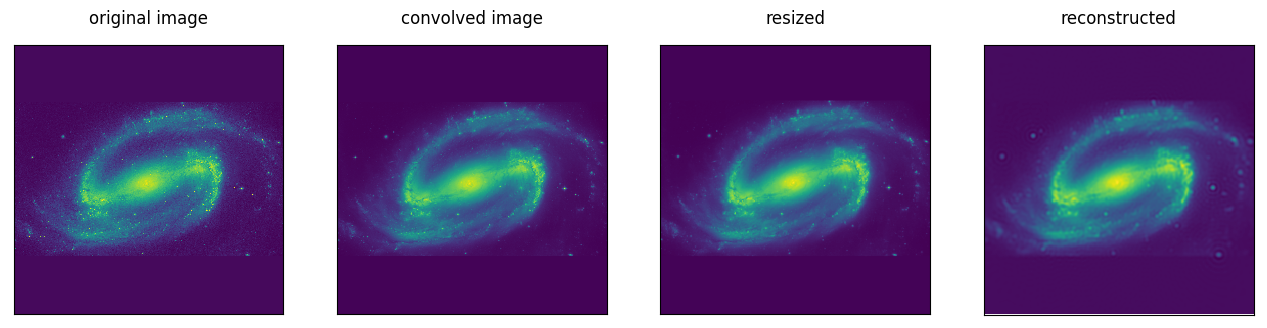

In [2]:
# import NGC1300 jpg image and decompose it

# find path to data
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
ngc_filename = os.path.join(module_path, 'Data/Galaxies/ngc1300.jpg')
# read data
ngc_data = scipy.ndimage.imread(ngc_filename, flatten=True, mode=None)
# subtract the median of an edge of the image
median = np.median(ngc_data[:200, :200])
ngc_data -= median

# resize the image to square size (add zeros at the edges of the non-square bits of the image)
nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
ngc_square = np.zeros((n_max, n_max))
x_start = int((n_max - nx)/2.)
y_start = int((n_max - ny)/2.)
ngc_square[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

# we slightly convolve the image with a Gaussian convolution kernel of a few pixels (optional)
sigma = 5
ngc_conv = scipy.ndimage.filters.gaussian_filter(ngc_square, sigma, mode='nearest', truncate=6)

# we now degrate the pixel resoluton by a factor.
# This reduces the data volume and increases the spead of the Shapelet decomposition
factor = 25  # lower resolution of image with a given factor
numPix_large = len(ngc_conv)/factor
n_new = (numPix_large-1)*factor
ngc_cut = ngc_conv[0:n_new,0:n_new]
x, y = util.make_grid(numPix=numPix_large-1, deltapix=1)  # make a coordinate grid
ngc_data_resized = image_util.re_size(ngc_cut, factor)  # re-size image to lower resolution

# now we come to the Shapelet decomposition
# we turn the image in a single 1d array
image_1d = util.image2array(ngc_data_resized)  # map 2d image in 1d data array

# we define the shapelet basis set we want the image to decompose in
n_max = 150  # choice of number of shapelet basis functions, 150 is a high resolution number, but takes long
beta = 10  # shapelet scale parameter (in units of resized pixels)

# import the ShapeletSet class
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapeletSet = ShapeletSet()

# decompose image and return the shapelet coefficients
coeff_ngc = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0) 
print len(coeff_ngc), 'number of coefficients'  # number of coefficients

# reconstruct NGC1300 with the shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, coeff_ngc, n_max, beta, center_x=0, center_y=0)
# turn 1d array back into 2d image
image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image

f, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=False, sharey=False)

ax = axes[0]
im = ax.matshow(ngc_square, origin='lower')
ax.set_title("original image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
im = ax.matshow(ngc_conv, origin='lower')
ax.set_title("convolved image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
im = ax.matshow(ngc_data_resized, origin='lower')
ax.set_title("resized")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
im = ax.matshow(image_reconstructed_2d, origin='lower')
ax.set_title("reconstructed")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

## simulation illustration with lenstronomy
In a next step, having a high resolution Shapelet decomposition of a galaxy, we illustrate how **lenstronomy** can be used to lens it and produce realistic images, including noise properties.
For further illustration, we present different simulations that produces outputs at the different steps of the computation, e.g. intrinsic source, + lensed on high resolution ray-tracing grid,+ convolution of the high resolution grid, + degrading to pixel resolution, + adding noise.

In [3]:
# define data specifics
background_rms = 10.  #  background noise per pixel
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 64  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
high_res_factor = 5
subgrid_res = high_res_factor  # we set the subgrid resolution to the high resolution image that we will show, so the same numerics will be applied.
fwhm = 0.1 # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'


# define lens model
lens_model_list = ['SPEP', 'SHEAR']
kwargs_spemd = {'theta_E': 0.5, 'gamma': 2., 'center_x':0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_shear = {'e1': 0.0, 'e2': 0.0}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# define center of the source (effectively the center of the Shapelet basis)
source_x = 0.2
source_y = 0.

# define the source size (effectively the Shapelet scale parameter)
beta_model = 0.06
# use the shapelet coefficients decomposed from NGC1300
coeff = coeff_ngc
kwargs_shapelet = {'n_max': n_max, 'beta': beta_model, 'amp': coeff, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SHAPELETS']
kwargs_source = [kwargs_shapelet]

# for this example, we do not include deflector light
lens_light_model_list = ['NONE']
kwargs_lens_light = [{}]

from lenstronomy.LensModel.lens_model import LensModel
lensModel = LensModel(lens_model_list)

from lenstronomy.LightModel.light_model import LightModel
sourceLightModel = LightModel(source_model_list)


In [4]:
# here we perform the computation with the settings choosen above.
# We set up the different Data and PSF classes to perform and return the output at various stages of the computation
from lenstronomy.SimulationAPI.simulations import Simulation
SimAPI = Simulation()
# final data configuration
data_real = SimAPI.data_configure(numPix, deltaPix, exp_time, background_rms)
# high resolution data configuration
data_high_res = SimAPI.data_configure(numPix*high_res_factor, deltaPix/high_res_factor, exp_time, background_rms)
# final psf configuration
psf = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=31, deltaPix=deltaPix, truncate=20, kernel=None)
# psf configuration performed on the high resolution gird (effectively the same convolution as the final psf)
psf_high_res = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=31, deltaPix=deltaPix/high_res_factor, truncate=6, kernel=None)
# no psf convolution
psf_no = SimAPI.psf_configure(psf_type='NONE')
# the numerics applied on the final data output to perform the identical computation as the high resolution gird
kwargs_numerics = {'subgrid_res': subgrid_res, 'psf_subgrid': True}

# and here we perform the computations
from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class=data_real, psf_class=psf_no, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_lensed = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_no_noise_lensed = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

poisson = image_util.add_poisson(image_no_noise_lensed, exp_time=exp_time)
bkg = image_util.add_background(image_no_noise_lensed, sigma_bkd=background_rms)
image_real_lensed = image_no_noise_lensed + poisson + bkg

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_high_res, kwargs_numerics={}, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_high_res_conv_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_high_res_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel_ = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, source_model_class=sourceLightModel)
image_high_res_nolens_large = imageModel_.image(kwargs_lens=None, kwargs_source=kwargs_source, kwargs_lens_light=None, kwargs_ps=None)


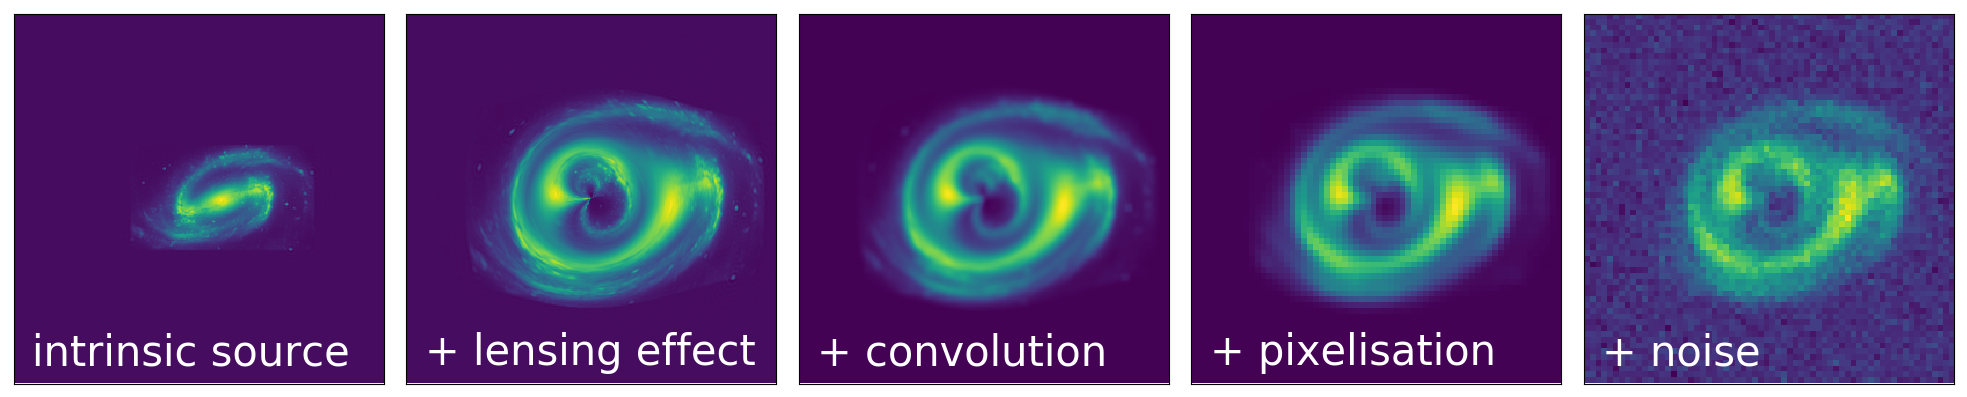

In [5]:
# the result is illustrated here

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = 0
v_max = 2

f, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)


ax = axes[0]
im = ax.matshow((image_high_res_nolens_large), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
    
ax = axes[1]
im = ax.matshow((image_high_res_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
im = ax.matshow((image_high_res_conv_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
im = ax.matshow((image_no_noise_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[4]
im = ax.matshow((image_real_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)


i = 0
ax = axes[0]
x_pos, y_pos = 0.05, 0.05
fontsize_description = 30
ax.text(x_pos, y_pos, "intrinsic source", color="w", fontsize=fontsize_description)
ax = axes[1]
ax.text(x_pos, y_pos, "+ lensing effect", color="w", fontsize=fontsize_description)
ax = axes[2]
ax.text(x_pos, y_pos, "+ convolution", color="w", fontsize=fontsize_description)
ax = axes[3]
ax.text(x_pos, y_pos, "+ pixelisation", color="w", fontsize=fontsize_description)
ax = axes[4]
ax.text(x_pos, y_pos, "+ noise", color="w", fontsize=fontsize_description)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/simAPI.pdf', format='pdf')
plt.show()

# lenstronomy shapelet reconstruction
Having simulated a realistic galaxy being lensed, convolved and added noise to the image, we can now turn the exercise around and ask how well we can reconstruct the intrinsic properties of the source galaxy given the (mock) data.

To do so, we use, as for the construction, a shapelet basis set. This time the scale and number of components are matched with the image properties and not the source properties. For this exercise, we fix the lens model to the "truth".

In [6]:
# update the data class with the realistc simulated image
data_real.update_data(image_real_lensed)
# initialize the ImageModel class
imageModel = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel)

kwargs_lens= [kwargs_spemd, kwargs_shear]  # we use the same lens model to reconstruct the image
n_max_reconstruct = 25 # we can change the source basis set order (we acctually have to do it due to the finite pixel resolution and psf)
beta_reconstruct = 0.15  # scaling can also be adopted
kwargs_source = [{'n_max': n_max_reconstruct, 'center_x': source_x, 'center_y': source_y, 'beta': beta_reconstruct}]

# this is the linear inversion
wls_model, _, cov_param, param = imageModel.image_linear_solve(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None, inv_bool=False)
lensed_reconstructed = wls_model

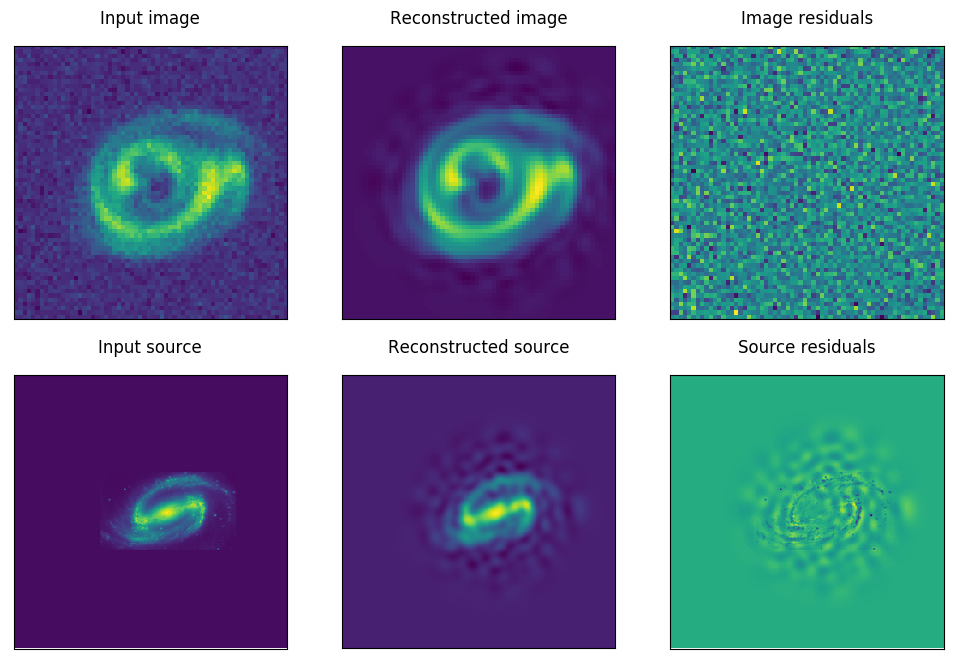

In [7]:
# given the solution of the linear inversion, we can also plot the coefficients in the source plane
x_coords, y_coords = data_high_res.coordinates
source_reconstructed = shapeletSet.function(util.image2array(x_coords), util.image2array(y_coords), param, n_max_reconstruct, beta_reconstruct, center_x=source_x, center_y=source_y)
source_reconstructed_2d = util.array2image(source_reconstructed)  # map 1d data vector in 2d image


f, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=False)
ax = axes[0,0]
ax.matshow(image_real_lensed, origin='lower')
ax.set_title("Input image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[0,1]
ax.matshow(wls_model, origin='lower')
ax.set_title("Reconstructed image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
# and here the reduced residuals

ax = axes[0,2]
reduced_residuals = imageModel.reduced_residuals(wls_model)
ax.matshow(reduced_residuals, origin='lower')
ax.set_title("Image residuals")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1,0]
ax.matshow(image_high_res_nolens_large, origin='lower')
ax.set_title("Input source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1,1]
ax.matshow(source_reconstructed_2d, origin='lower')
ax.set_title("Reconstructed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

# and here the residuals relative to the true input source
ax = axes[1,2]
ax.matshow(source_reconstructed_2d - image_high_res_nolens_large, origin='lower')
ax.set_title("Source residuals")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/de_lens_shapelets.pdf', format='pdf')


plt.show()



## Deconvolution with lenstronomy
**lenstronomy** can also be used without imposing a lensing deflector. The **lenstronomy** routine, that allows for de-lensing and de-convolution can also be applied for de-convolution purposes only. 

Specific software packages and algorithm that are designed to perform these task may well be faster and optimized. We want to demonstrate the flexibility of **lenstronomy** and where speed may not be the primary requirement, we can provide an alternative.

In [8]:
# let's start with the same galaxy, but double its physical size relative to the lensed example
# we keep the same data and quantities and a bit a more blury psf
fwhm_deconv = 0.25
psf_deconv = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm_deconv, kernelsize=31, deltaPix=deltaPix, truncate=20, kernel=None)
psf_deconv_high_res = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm_deconv, kernelsize=31, deltaPix=deltaPix/high_res_factor, truncate=6, kernel=None)


# define center of the source (effectively the center of the Shapelet basis)
source_x = 0.
source_y = 0.

# define the source size (effectively the Shapelet scale parameter)
beta_model = 0.12
# use the shapelet coefficients decomposed from NGC1300, but make them 10 times brighter
coeff_deconv = coeff_ngc * 5
kwargs_shapelet = {'n_max': n_max, 'beta': beta_model, 'amp': coeff_deconv, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SHAPELETS']
kwargs_light = [kwargs_shapelet]

#from lenstronomy.LensModel.lens_model import LensModel
#lensModel = LensModel(lens_model_list)

from lenstronomy.LightModel.light_model import LightModel
lightModel = LightModel(source_model_list)



imageModel = ImageModel(data_class=data_real, psf_class=psf_deconv, kwargs_numerics=kwargs_numerics, lens_model_class=None, lens_light_model_class=lightModel)
image_no_noise = imageModel.image(kwargs_lens=None, kwargs_source=None, kwargs_lens_light=kwargs_light, kwargs_ps=None)

poisson = image_util.add_poisson(image_no_noise, exp_time=exp_time)
bkg = image_util.add_background(image_no_noise, sigma_bkd=background_rms)
image_real = image_no_noise + poisson + bkg

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_deconv_high_res, kwargs_numerics={}, lens_model_class=None, lens_light_model_class=lightModel)
image_high_res_conv = imageModel_high_res.image(kwargs_lens=None, kwargs_source=None, kwargs_lens_light=kwargs_light, kwargs_ps=None)

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, lens_model_class=None, lens_light_model_class=lightModel)
image_high_res = imageModel_high_res.image(kwargs_lens=None, kwargs_source=None, kwargs_lens_light=kwargs_light, kwargs_ps=None)


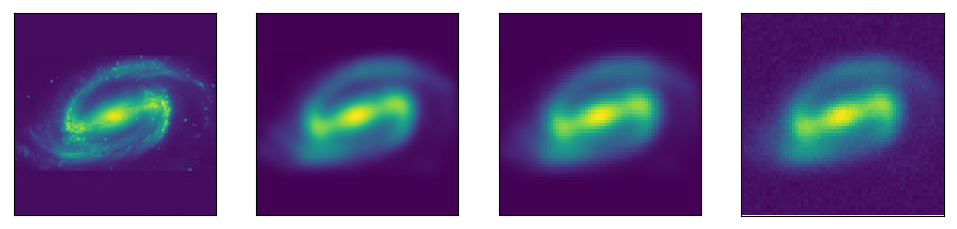

In [9]:
f, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=False, sharey=False)


ax = axes[0]
im = ax.matshow((image_high_res), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
    
ax = axes[1]
im = ax.matshow((image_high_res_conv), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
im = ax.matshow((image_no_noise), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
im = ax.matshow((image_real), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [10]:
# update the data class with the realistc simulated image
data_real.update_data(image_real)
# initialize the ImageModel class
imageModel = ImageModel(data_class=data_real, psf_class=psf_deconv, kwargs_numerics=kwargs_numerics, lens_model_class=None, lens_light_model_class=lightModel)
n_max_reconstruct = 20 # we can change the source basis set order (we acctually have to do it due to the finite pixel resolution and psf)
beta_reconstruct = 0.3  # scaling can also be adopted
kwargs_reconstruct = [{'n_max': n_max_reconstruct, 'center_x': source_x, 'center_y': source_y, 'beta': beta_reconstruct}]

# this is the linear inversion
wls_model, _, cov_param, param = imageModel.image_linear_solve(kwargs_lens=None, kwargs_source=None, kwargs_lens_light=kwargs_reconstruct, kwargs_ps=None, inv_bool=False)
lensed_reconstructed = wls_model

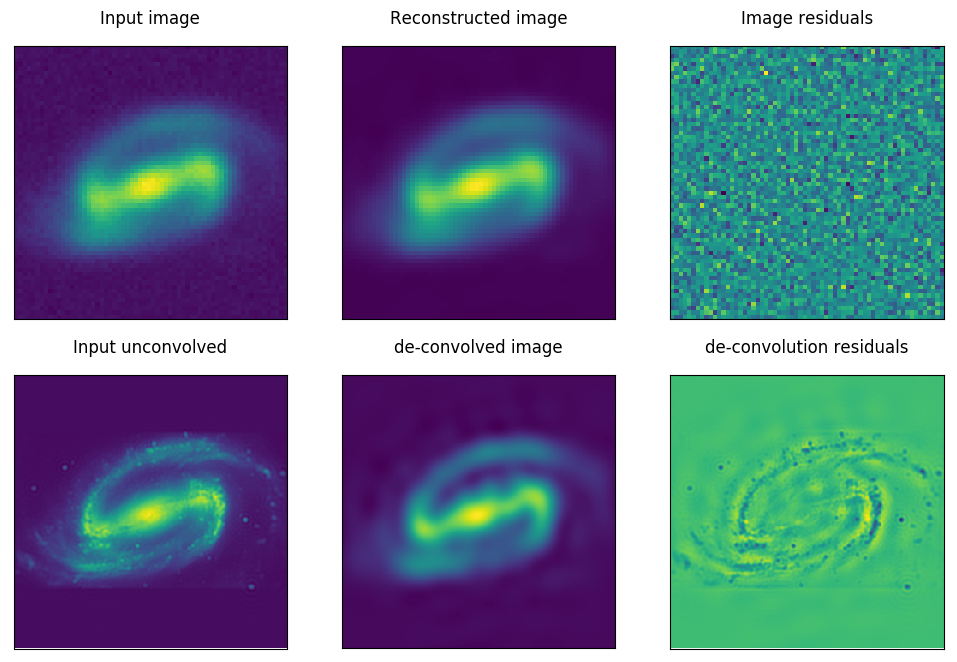

In [11]:
# given the solution of the linear inversion, we can also plot the coefficients in the source plane
x_coords, y_coords = data_high_res.coordinates
source_deconvolved = shapeletSet.function(util.image2array(x_coords), util.image2array(y_coords), param, n_max_reconstruct, beta_reconstruct, center_x=source_x, center_y=source_y)
source_deconvolved = util.array2image(source_deconvolved)  # map 1d data vector in 2d image


f, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=False)
ax = axes[0,0]
ax.matshow(image_real, origin='lower')
ax.set_title("Input image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[0,1]
ax.matshow(wls_model, origin='lower')
ax.set_title("Reconstructed image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
# and here the reduced residuals

ax = axes[0,2]
reduced_residuals = imageModel.reduced_residuals(wls_model)
ax.matshow(reduced_residuals, origin='lower')
ax.set_title("Image residuals")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1,0]
ax.matshow(image_high_res, origin='lower')
ax.set_title("Input unconvolved")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1,1]
ax.matshow(source_deconvolved, origin='lower')
ax.set_title("de-convolved image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

# and here the residuals relative to the true input source
ax = axes[1,2]
ax.matshow(source_deconvolved - image_high_res, origin='lower')
ax.set_title("de-convolution residuals")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()
